# Vectorized $X_{wt}$

**Motivation:** I tried looking at the $t\bar{t}$ distributions for pairAGraph, and it seemed like it was *quite* a bit higher than we were expecting. One of the reasons why this could have been is ...

In [36]:
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import gridspec

import json
import time
import h5py
import uproot
from uproot_methods.classes.TLorentzVector import TLorentzVectorArray
import torch

# from trainNet import pairAGraph
# from preprocess import truthInfo, parallelTruthMatchJets, parallelGetCorrectPair
# from preprocess import processDf, scale, applyCuts, pairAndProcess

import os
os.sys.path.append('../code')
from analysis import fileDir, normalizeWeight, read_tsv, getXhh
from AnalysisUtils import nanoToDf
from eventDisplays import truthDisplay


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


I want to put this calculation inside `processDf`, so I'm going to copy the relevant function here below for easier manipulation, and then I'll put the logic back in!

In [3]:
# Open the file
filename = "../../public/hh4b/kappa_lambda/user.valentem.HH4B.600043.HH_NLO.MC16a-2015-2016.AB21.2.91-APR20-1.full_MiniNTuple.root/user.valentem.21562918._000001.MiniNTuple.root"
treename = "XhhMiniNtuple" 

print(f"\nOpening {filename}")
f = uproot.open(filename)
tree = f[treename]

print('Loading in the event df')
evt_vars = ['eventNumber', 'nresolvedJets','weight_pileup']
evt_vars += [f'resolved_{e}' for e in ['nBTags','nValidPairings','isSR','isCR','isSB','nGoodJets']]
evt_vars += ['mcEventWeight','rand_run_nr']

df = tree.pandas.df(evt_vars)


Opening ../../public/hh4b/kappa_lambda/user.valentem.HH4B.600043.HH_NLO.MC16a-2015-2016.AB21.2.91-APR20-1.full_MiniNTuple.root/user.valentem.21562918._000001.MiniNTuple.root
Loading in the event df


In [11]:
nJetsMax = 5
pT_min = 40
eta_max = 2.5

In [212]:
# Get the jets
jet_vars = ['pt','eta','phi','E','is_DL1r_FixedCutBEff_77','Quantile_DL1r_Continuous','SF_DL1r_Continuous']
jVars = ['pt','eta','phi','E','Db','sf']

pre = 'resolvedJets'
jet_vars = [f'{pre}_{v}' for v in jet_vars]
myCols = [f'j{i}_{v}' for i in range(nJetsMax) for v in jVars] + ['njets']
for c in myCols:
    df[c] = 0

print('Loading in the jet array')
arr = tree.arrays(jet_vars)

Loading in the jet array


In [233]:
ks = [v.encode() for v in jet_vars[:5]]

for nresJets in range(4,np.max(df.nresolvedJets)+1):

    mask = (df['nresolvedJets'] == nresJets)
    if np.sum(mask) == 0: continue

    # Use the jet pt and eta functions to define masks
    jpts  = arr[b'resolvedJets_pt'][mask].flatten().reshape(-1, nresJets)
    jetas = arr[b'resolvedJets_eta'][mask].flatten().reshape(-1,nresJets)

    jmask = (jpts > pT_min) & (np.abs(jetas) < eta_max)

    njets = np.sum(jmask,axis = 1)

    for nj in range(np.min(njets),nresJets+1):

        m = mask.copy()
        m[mask] = (njets == nj)
        N = min(nj,nJetsMax)

        if (np.sum(m) == 0) or (np.sum(jmask[njets == nj]) == 0): continue
        
        for v,w in zip(jVars[:5], jVars[:4]+['Quantile_DL1r_Continuous']):
            k = f'resolvedJets_{w}'.encode()

            jarr = arr[k][m].flatten().reshape(-1,nresJets)[jmask[njets == nj]].reshape(-1,nj)
            df.loc[m,[f'j{i}_{v}' for i in range(N)]] = jarr if N < nJetsMax else jarr[:,:N]

        print(f'  Jet sfs for evts with {nj} selected jets out of {nresJets} resolved jets')
        sf_arr = np.array([[ci[0] for ci in c] for c in arr[f'{pre}_SF_DL1r_Continuous'.encode()][m]])[jmask[njets == nj]].reshape(-1,nj)
        df.loc[m,[f'j{i}_sf'  for i in range(N)]] = sf_arr if N < nJetsMax else sf_arr[:,:N] 
         
            
        if nj >= 4:
            arr_3d = np.dstack([arr[k][m].flatten().reshape(-1,nresJets)[jmask[njets == nj]].reshape(-1,nj) 
                                for k in ks])
            df.loc[m,'X_wt'] = parallelXwt(arr_3d)
        
        #break
    if nresJets == 4:
        break
            

  Jet sfs for evts with 1 selected jets out of 4 resolved jets
  Jet sfs for evts with 2 selected jets out of 4 resolved jets
  Jet sfs for evts with 3 selected jets out of 4 resolved jets
  Jet sfs for evts with 4 selected jets out of 4 resolved jets


In [218]:
arr_3d#.shape

array([[[ 1.25709763e+02, -2.30736285e-01, -2.94830084e+00,
          1.30686981e+02,  1.00000000e+00],
        [ 1.19333145e+02,  5.72734118e-01,  2.60399604e+00,
          1.41067734e+02,  1.00000000e+00],
        [ 9.56132126e+01, -1.86824799e-02,  1.00799970e-01,
          9.70450821e+01,  0.00000000e+00],
        [ 7.04632950e+01, -1.07655704e+00, -1.27752617e-01,
          1.15794556e+02,  1.00000000e+00]],

       [[ 1.46412857e+02,  1.56562924e+00, -2.45917583e+00,
          3.65926483e+02,  1.00000000e+00],
        [ 1.36704987e+02,  3.01963240e-01,  8.59001398e-01,
          1.44295959e+02,  1.00000000e+00],
        [ 7.60934067e+01,  1.21135068e+00,  3.56665224e-01,
          1.40038498e+02,  1.00000000e+00],
        [ 5.59719505e+01,  4.32728648e-01, -2.46088362e+00,
          6.23116875e+01,  0.00000000e+00]],

       [[ 1.20834465e+02,  1.22954047e+00,  1.24745035e+00,
          2.25009903e+02,  1.00000000e+00],
        [ 6.87333679e+01,  1.48735249e+00, -1.17760026e+00,


/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/uproot_methods/classes/TLorentzVector.py:843: RuntimeWarning: overflow encountered in sinh
  pt * cls.awkward.numpy.sinh(eta),
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/uproot_methods/classes/TLorentzVector.py:843: RuntimeWarning: overflow encountered in multiply
  pt * cls.awkward.numpy.sinh(eta),


In [166]:
len(ps)

6

In [164]:
i=5

In [165]:
TLorentzVectorArray.from_ptetaphie(*arr_3d[:,i,:4].T)

<TLorentzVectorArray [TLorentzVector(x=19.191, y=-53.093, z=8.3677e+22, t=-0.51904) TLorentzVector(x=18.124, y=-192.48, z=3.1403e+25, t=-1.9449) TLorentzVector(x=-44.511, y=20.296, z=4.5491e+20, t=-0.42308) ... TLorentzVector(x=30.181, y=-35.953, z=2.1727e+21, t=-0.17544) TLorentzVector(x=-54.708, y=12.718, z=9.9854e+22, t=0.47807) TLorentzVector(x=28.271, y=77.65, z=2.6624e+21, t=-1.1935)] at 0x7fd57c655850>

In [230]:
def parallelXwt(arr_3d):
    '''
    Input: 
    - arr_3d: An array of shape nEvents,nJets,nFeatures where the features are assumed
              to be (pt, eta, phi, E, b-tag boolean)
    '''
    
    nEvt, nj, nFeat = arr_3d.shape
    
    ps = [ TLorentzVectorArray.from_ptetaphie(*(arr_3d[:,i,:4].T)) for i in range(nj) ]
    
    Xwt_arr = np.zeros((nEvt,nj,int(comb(nj-1,2))))

    for ib, bjet  in enumerate(ps):

        # Get the jets valid for reconstructing the W-candidate
        other = [pi for i,pi in enumerate(ps) if i != ib]
        for j, (wjet1, wjet2) in enumerate(combinations(other,2)):

            W = wjet1 + wjet2

            Xwt = getXhh(W, bjet+W, mlead_mean=80.4, msubl_mean=172.5) 
            Xwt_arr[:,ib,j] = Xwt


    # Only consider b-tagged jets as the b from the top decay 
    mask = arr_3d[:,:,-1].astype(bool)
    mask[mask.sum(axis=1)>4,-1] = False
    mask = mask.reshape(nEvt,nj,1)
    
    Xwt_arr = np.where(~mask, np.inf, Xwt_arr) 

    return np.min(Xwt_arr.reshape(nEvt,-1),axis=1)



In [229]:
nEvt, nj, nFeat = arr_3d.shape

ps = [ TLorentzVectorArray.from_ptetaphi(*(arr_3d[:,i,:4].T)) for i in range(nj) ]

Xwt_arr = np.zeros((nEvt,nj,int(comb(nj-1,2))))

for ib, bjet  in enumerate(ps):

    # Get the jets valid for reconstructing the W-candidate
    other = [pi for i,pi in enumerate(ps) if i != ib]
    for j, (wjet1, wjet2) in enumerate(combinations(other,2)):

        W = wjet1 + wjet2

        Xwt = getXhh(W, bjet+W, mlead_mean=80.4, msubl_mean=172.5) 
        Xwt_arr[:,ib,j] = Xwt


# Only consider b-tagged jets as the b from the top decay 
mask = arr_3d[:,:,-1].astype(bool)
mask[mask.sum(axis=1)>4,-1] = False
mask = mask.reshape(nEvt,nj,1)

np.where(~mask, np.inf, Xwt_arr) 

print(np.min(Xwt_arr.reshape(nEvt,-1),axis=1))



[4.87212358 4.34275089 2.67054378 ... 2.26280957 4.34513164 3.60793072]


In [224]:
TLorentzVectorArray.from_ptetaphi(*(arr_3d[:,0,:4].T)).mass

array([20.48826266, 14.47968667, 18.18467361, ..., 15.54606254,
       18.74889586, 19.43534855])

In [225]:
ps[0]

<TLorentzVectorArray [TLorentzVector(x=-128.25, y=-25.104, z=2.5719e+56, t=-0.23074) TLorentzVector(x=-283.98, y=-230.78, z=7.0576e+65, t=1.5656) TLorentzVector(x=71.495, y=213.35, z=3.38e+54, t=1.2295) ... TLorentzVector(x=-17.968, y=-248.24, z=3.3761e+109, t=0.0912) TLorentzVector(x=-345.83, y=-20.293, z=8.3092e+81, t=-1.2481) TLorentzVector(x=-23.565, y=-182.95, z=1.3287e+79, t=-0.2541)] at 0x7fd57c7f6590>

In [204]:
W

<TLorentzVectorArray [TLorentzVector(x=-24.617, y=82.003, z=4.722e+53, t=0.55405) TLorentzVector(x=225.48, y=158.15, z=1.6922e+61, t=1.5133) TLorentzVector(x=61.354, y=-212.05, z=5.6772e+31, t=1.6849) ... TLorentzVector(x=53.092, y=271.13, z=2.3008e+88, t=-0.70527) TLorentzVector(x=494.09, y=-47.064, z=2.9536e+43, t=-3.9562) TLorentzVector(x=44.913, y=171.6, z=5.6437e+75, t=-1.7081)] at 0x7fd57bcbb310>

In [196]:
ps[-1].phi

array([-0.12775262, -2.46088362,  2.42443943, ..., -2.4846642 ,
       -2.85661101, -1.37484384])

In [198]:
ps

[<TLorentzVectorArray [TLorentzVector(x=-128.25, y=-25.104, z=2.5719e+56, t=-0.23074) TLorentzVector(x=-283.98, y=-230.78, z=7.0576e+65, t=1.5656) TLorentzVector(x=71.495, y=213.35, z=3.38e+54, t=1.2295) ... TLorentzVector(x=-17.968, y=-248.24, z=3.3761e+109, t=0.0912) TLorentzVector(x=-345.83, y=-20.293, z=8.3092e+81, t=-1.2481) TLorentzVector(x=-23.565, y=-182.95, z=1.3287e+79, t=-0.2541)] at 0x7fd57ca3bdd0>,
 <TLorentzVectorArray [TLorentzVector(x=-121.17, y=72.237, z=4.722e+53, t=0.57273) TLorentzVector(x=94.253, y=109.26, z=1.6922e+61, t=0.30196) TLorentzVector(x=61.312, y=-147.81, z=5.6713e+31, t=1.4874) ... TLorentzVector(x=17.656, y=222.65, z=2.3008e+88, t=-0.46755) TLorentzVector(x=196.79, y=97.301, z=2.9536e+43, t=-1.474) TLorentzVector(x=35.89, y=236.48, z=5.6437e+75, t=-0.87476)] at 0x7fd57bcf0450>,
 <TLorentzVectorArray [TLorentzVector(x=96.552, y=9.7656, z=1.6227e+43, t=-0.018682) TLorentzVector(x=131.23, y=48.895, z=7.8012e+34, t=1.2114) TLorentzVector(x=0.042085, y=-64.

In [197]:
other

[<TLorentzVectorArray [TLorentzVector(x=-128.25, y=-25.104, z=2.5719e+56, t=-0.23074) TLorentzVector(x=-283.98, y=-230.78, z=7.0576e+65, t=1.5656) TLorentzVector(x=71.495, y=213.35, z=3.38e+54, t=1.2295) ... TLorentzVector(x=-17.968, y=-248.24, z=3.3761e+109, t=0.0912) TLorentzVector(x=-345.83, y=-20.293, z=8.3092e+81, t=-1.2481) TLorentzVector(x=-23.565, y=-182.95, z=1.3287e+79, t=-0.2541)] at 0x7fd57ca3bdd0>,
 <TLorentzVectorArray [TLorentzVector(x=-121.17, y=72.237, z=4.722e+53, t=0.57273) TLorentzVector(x=94.253, y=109.26, z=1.6922e+61, t=0.30196) TLorentzVector(x=61.312, y=-147.81, z=5.6713e+31, t=1.4874) ... TLorentzVector(x=17.656, y=222.65, z=2.3008e+88, t=-0.46755) TLorentzVector(x=196.79, y=97.301, z=2.9536e+43, t=-1.474) TLorentzVector(x=35.89, y=236.48, z=5.6437e+75, t=-0.87476)] at 0x7fd57bcf0450>,
 <TLorentzVectorArray [TLorentzVector(x=96.552, y=9.7656, z=1.6227e+43, t=-0.018682) TLorentzVector(x=131.23, y=48.895, z=7.8012e+34, t=1.2114) TLorentzVector(x=0.042085, y=-64.

In [190]:
mask

array([[1., 1., 0., 1.],
       [1., 1., 1., 0.],
       [1., 1., 0., 1.],
       ...,
       [0., 1., 1., 0.],
       [1., 1., 1., 1.],
       [1., 1., 0., 1.]])

In [187]:
mask.reshape(nEvt,nj,1).shape

(73324, 4, 1)

In [189]:
Xwt_arr[:,:]

array([[[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]])

In [186]:
Xwt_arr[~mask.reshape(nEvt,nj,1)]

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [183]:
mask.shape

(73324, 4)

In [178]:
mask.shape

(73324, 4)

In [179]:
Xwt_arr.shape

(73324, 4, 3)

In [180]:
np.where(~mask.reshape(nEvt,nj,1),np.inf,Xwt_arr)

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [174]:
mask

array([[1., 1., 0., 1.],
       [1., 1., 1., 0.],
       [1., 1., 0., 1.],
       ...,
       [0., 1., 1., 0.],
       [1., 1., 1., 1.],
       [1., 1., 0., 1.]])

In [132]:
jet_vars

['resolvedJets_E',
 'resolvedJets_pt',
 'resolvedJets_phi',
 'resolvedJets_eta',
 'resolvedJets_is_DL1r_FixedCutBEff_77',
 'resolvedJets_Quantile_DL1r_Continuous',
 'resolvedJets_SF_DL1r_Continuous']

In [125]:
k

b'resolvedJets_Quantile_DL1r_Continuous'

6

In [130]:
arr[k][m].flatten().reshape(-1,nresJets)[jmask[njets == nj]].reshape(-1,nj).shape

(10768, 6)

In [151]:
ks = [v.encode() for v in jet_vars[:5]]
ks

[b'resolvedJets_E',
 b'resolvedJets_pt',
 b'resolvedJets_phi',
 b'resolvedJets_eta',
 b'resolvedJets_is_DL1r_FixedCutBEff_77']

In [150]:
k

b'resolvedJets_Quantile_DL1r_Continuous'

In [149]:
arr[k]

<JaggedArray [[5 1 5 1 1 1] [5 5 1 2 1 -1] [5 1 1 -1 5] ... [1 5 1 ... 1 1 5] [5 5 5 ... -1 5 5] [5 -1 -1 5 1 -1]] at 0x7fd58c55f150>

In [154]:
np.dstack([arr[k][m].flatten().reshape(-1,nresJets)[jmask[njets == nj]].reshape(-1,nj) for k in ks]).shape

(10768, 6, 5)

In [15]:
?itertools.combinations

In [16]:
from itertools import combinations

**First goal:** I just wanted to just calculate the $X_{wt}$ over the first 4 jets in the event, I can just construct all of the 4-vectors manually.

In [18]:
np.sum(m)

73324

In [23]:
df.loc[m,[f'j0_{v}' for v in jVars[:4]]].values.T.shape

(4, 73324)

In [29]:
j0 = TLorentzVectorArray.from_ptetaphie(*df.loc[m,[f'j0_{v}' for v in jVars[:4]]].values.T)
j1 = TLorentzVectorArray.from_ptetaphie(*df.loc[m,[f'j1_{v}' for v in jVars[:4]]].values.T)
j2 = TLorentzVectorArray.from_ptetaphie(*df.loc[m,[f'j2_{v}' for v in jVars[:4]]].values.T)
j3 = TLorentzVectorArray.from_ptetaphie(*df.loc[m,[f'j3_{v}' for v in jVars[:4]]].values.T)

Sanity checking the lines above are doing what I'm thinking.

In [26]:
df.loc[m,[f'j0_{v}' for v in jVars[:4]]].head()

j0_pt    j0_eta    j0_phi        j0_E
entry                                            
19     125.709763 -0.230736 -2.948301  130.686981
39     146.412857  1.565629 -2.459176  365.926483
53     120.834465  1.229540  1.247450  225.009903
62     259.052643 -0.716189  0.353503  329.000397
67     180.147369 -0.954925 -0.690409  269.051422

In [30]:
j0.pt,j0.eta,j0.phi,j0.E

(array([125.70976257, 146.41285706, 120.83446503, ..., 247.37461853,
        183.47224426, 177.66413879]),
 array([-0.23073629,  1.56562924,  1.22954047, ...,  0.09120032,
        -1.24809921, -0.25409627]),
 array([-2.94830084, -2.45917583,  1.24745035, ..., -1.64304984,
        -3.08298182, -1.69889987]),
 array([130.6869812 , 365.92648315, 225.00990295, ..., 248.89009094,
        346.42306519, 184.45726013]))

Sanity check passed.

In [31]:
ps = [j0,j1,j2,j3]
idx = [0,1,2,3]

In [33]:
for ia,ib,ic in combinations(idx,3):
    print(ia,ib,ic)

0 1 2
0 1 3
0 2 3
1 2 3


In [155]:
# for ja,jb,jc in combinations(ps,3):
#     print(ja,jb,jc)

In [42]:
from scipy.special import comb

In [68]:
df['X_wt'] = -1

In [82]:
df.loc[m,[f'j{i}_Db' for i in range(4)]].tail()

j0_Db  j1_Db  j2_Db  j3_Db
entry                             
686669      1      5      4      5
686674      4      1      5      1
686675      2      4      3      2
686695      5      5      5      5
686697      5      5      1      5

In [70]:
len(ps)

4

In [86]:
Xwt_arr = np.zeros((np.sum(m),4,int(comb(3,2))))
Dbs = df.loc[m,[f'j{i}_Db' for i in range(4)]].values

for ib, bjet  in enumerate(ps):
    
    # Get the jets valid for reconstructing the W-candidate
    other = [pi for i,pi in enumerate(ps) if i != ib]
    
    for j, (wjet1, wjet2) in enumerate(combinations(other,2)):
        
        
        W = wjet1 + wjet2
        
        Xwt = getXhh(W, bjet+W, mlead_mean=80.4, msubl_mean=172.5) 
    
        Xwt_arr[:,ib,j] = Xwt
        #print(Xwt)
        
# Only consider b-tagged jets as the b from the top decay 
Dbs = df.loc[m,[f'j{i}_Db' for i in range(4)]].values
mask = (Dbs >= 3).reshape(np.sum(m),4,1)
Xwt_arr = np.where(~mask, np.inf, Xwt_arr) 
   
df.loc[m,'X_wt'] = np.min(Xwt_arr.reshape(np.sum(m),-1),axis=1)
    

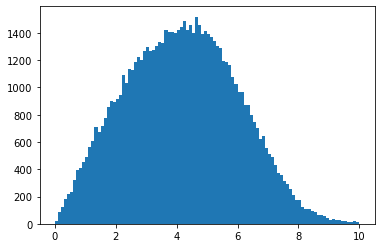

In [89]:
plt.hist(df.loc[m,'X_wt'],100,(0,10))
plt.show()

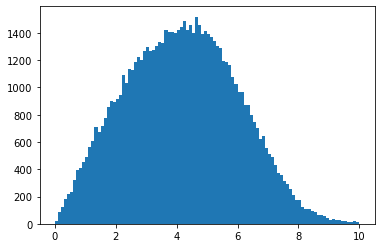

In [234]:
plt.hist(df.loc[m,'X_wt'],100,(0,10))
plt.show()

In [79]:
Xwt_arr[0]

array([[7.97378236, 8.45885629, 4.87212358],
       [8.06961611, 7.92656131, 5.2429203 ],
       [       inf,        inf,        inf],
       [6.62764148, 7.86156572, 8.00108377]])

In [83]:
Xwt_arr[-3]

array([[        inf,         inf,         inf],
       [ 9.38894746,  6.73924063,  3.20005022],
       [10.64643233,  3.92061087,  6.051465  ],
       [        inf,         inf,         inf]])

**Step 2:** Events with 5 selected jets

In [92]:
np.sum(m)

33253

In [93]:
ps = [TLorentzVectorArray.from_ptetaphie(*df.loc[m,[f'j{i}_{v}' for v in jVars[:4]]].values.T) 
      for i in range(5)]

In [94]:
len(ps)

5

In [111]:
N

5

In [113]:
Xwt_arr = np.zeros((np.sum(m),N,int(comb(N-1,2))))
Dbs = df.loc[m,[f'j{i}_Db' for i in range(N)]].values

for ib, bjet  in enumerate(ps):
    
    # Get the jets valid for reconstructing the W-candidate
    other = [pi for i,pi in enumerate(ps) if i != ib]
    
    for j, (wjet1, wjet2) in enumerate(combinations(other,2)):
        
        
        W = wjet1 + wjet2
        
        Xwt = getXhh(W, bjet+W, mlead_mean=80.4, msubl_mean=172.5) 
    
        Xwt_arr[:,ib,j] = Xwt
        #print(Xwt)
        
# Only consider b-tagged jets as the b from the top decay 
Dbs = df.loc[m,[f'j{i}_Db' for i in range(N)]].values
mask = (Dbs >= 3)

In [114]:
mask.sum(axis=1).max()

5

In [116]:
Xwt_arr[mask.sum(axis=1)>4][0]

array([[7.72292896, 6.53789661, 5.9843504 , 5.45295021, 5.27996707,
        6.13580656],
       [8.28294887, 8.91473945, 7.97550596, 3.2640425 , 3.82438022,
        3.65564376],
       [8.62799288, 8.71235469, 7.74050915, 4.48285003, 4.34362383,
        3.31144202],
       [8.70788139, 8.15013645, 8.1134555 , 6.19519339, 3.70776531,
        2.66613138],
       [8.39776859, 7.80988378, 8.73998644, 6.22723904, 3.9210311 ,
        1.88000823]])

In [118]:
mask.shape

(33253, 5)

In [120]:
mask[mask.sum(axis=1)>4,-1] = False

In [121]:
mask

array([[ True, False,  True,  True, False],
       [ True,  True,  True,  True, False],
       [ True,  True, False, False,  True],
       ...,
       [False,  True,  True,  True, False],
       [False,  True, False,  True,  True],
       [ True,  True,  True,  True, False]])

In [122]:

mask = mask.reshape(np.sum(m),N,1)
Xwt_arr = np.where(~mask, np.inf, Xwt_arr) 
   
df.loc[m,'X_wt'] = np.min(Xwt_arr.reshape(np.sum(m),-1),axis=1)
    

In [123]:
df.loc[m,'X_wt']

entry
3         2.328653
20        2.666131
28        0.937525
45        4.755169
78        1.354474
            ...   
686569    2.334658
686582    4.894231
686623    1.039819
686651    4.004168
686705    5.418908
Name: X_wt, Length: 33253, dtype: float64

**Step 3:** 6 selected jets!


In [235]:
70/np.sqrt(2)

49.49747468305832